# Assignment 1. Music Century Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build models to predict which
**century** a piece of music was released.  We will be using the "YearPredictionMSD Data Set"
based on the Million Song Dataset. The data is available to download from the UCI 
Machine Learning Repository. Here are some links about the data:

- https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
- http://millionsongdataset.com/pages/tasks-demos/#yearrecognition

Note that you are note allowed to import additional packages **(especially not PyTorch)**. One of the objectives is to understand how the training procedure actually operates, before working with PyTorch's autograd engine which does it all for us.


## Question 1. Data (21%)

Start by setting up a Google Colab notebook in which to do your work.
Since you are working with a partner, you might find this link helpful:

- https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

The recommended way to work together is pair coding, where you and your partner are sitting together and writing code together. 

To process and read the data, we use the popular `pandas` package for data analysis.

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

Now that your notebook is set up, we can load the data into the notebook. The code below provides
two ways of loading the data: directly from the internet, or through mounting Google Drive.
The first method is easier but slower, and the second method is a bit involved at first, but
can save you time later on. You will need to mount Google Drive for later assignments, so we recommend
figuring how to do that now.

Here are some resources to help you get started:

- http.://colab.research.google.com/notebooks/io.ipynb

In [2]:
load_from_drive = True

if not load_from_drive:
  csv_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
else:
  from google.colab import drive
  drive.mount('/content/gdrive')
  csv_path = '/content/gdrive/Shareddrives/Deep learning/YearPredictionMSD.txt' # TODO - UPDATE ME WITH THE TRUE PATH!

t_label = ["year"]
x_labels = ["var%d" % i for i in range(1, 91)]
df = pandas.read_csv(csv_path, names=t_label + x_labels)

Mounted at /content/gdrive


In [3]:
df

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.0500

To set up our data for classification, we'll use the "year" field to represent
whether a song was released in the 20-th century. In our case `df["year"]` will be 1 if
the year was released after 2000, and 0 otherwise.

In [4]:
df["year"] = df["year"].map(lambda x: int(x > 2000))

In [5]:
df.head(20)

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,1,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,1,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,1,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,1,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34

### Part (a) -- 7%

The data set description text asks us to respect the below train/test split to
avoid the "producer effect". That is, we want to make sure that no song from a single artist
ends up in both the training and test set.

Explain why it would be problematic to have
some songs from an artist in the training set, and other songs from the same artist in the
test set. (Hint: Remember that we want our test accuracy to predict how well the model
will perform in practice on a song it hasn't learned about.)

In [6]:
df_train = df[:463715]
df_test = df[463715:]

# convert to numpy
train_xs = df_train[x_labels].to_numpy()
train_ts = df_train[t_label].to_numpy()
test_xs = df_test[x_labels].to_numpy()
test_ts = df_test[t_label].to_numpy()

# Write your explanation here
# Answer: The test set should check the prediction accuracy by checking how good the model have learned with the same data. It would be problematic to have some songs from an artist in the training set, and other songs from the same artist in the test set because we want to test the same data that the model have learned and .

### Part (b) -- 7%

It can be beneficial to **normalize** the columns, so that each column (feature)
has the *same* mean and standard deviation.

In [7]:
feature_means = df_train.mean()[1:].to_numpy() # the [1:] removes the mean of the "year" field
feature_stds  = df_train.std()[1:].to_numpy()

feature_means = df_train.mean()[1:].to_numpy() # the [1:] removes the mean of the "year" field
feature_stds  = df_train.std()[1:].to_numpy()

train_norm_xs = (train_xs - feature_means) / feature_stds
test_norm_xs = (test_xs - feature_means) / feature_stds

Notice how in our code, we normalized the test set using the *training data means and standard deviations*.
This is *not* a bug.

Explain why it would be improper to compute and use test set means
and standard deviations. (Hint: Remember what we want to use the test accuracy to measure.)

In [ ]:
# Write your explanation here
# Answer: We should use the same means and standart deviation from the train set to normalize the test set because we want to preserve the
# same relationship between the features and the labels that we used when we trained the data set. If we would use another numbers to
# normalize the test data that we obtain from the test set then we would change the relationship between the features and the labels
# differently from what the model learned.  

### Part (c) -- 7%

Finally, we'll move some of the data in our training set into a validation set.

Explain why we should limit how many times we use the test set, and that we should use the validation
set during the model building process.

In [8]:
# shuffle the training set
reindex = np.random.permutation(len(train_xs))
train_xs = train_xs[reindex]
train_norm_xs = train_norm_xs[reindex]
train_ts = train_ts[reindex]

# use the first 50000 elements of `train_xs` as the validation set
train_xs, val_xs           = train_xs[50000:], train_xs[:50000]
train_norm_xs, val_norm_xs = train_norm_xs[50000:], train_norm_xs[:50000]
train_ts, val_ts           = train_ts[50000:], train_ts[:50000]

# Write your explanation here
# If we use the same test set each time we may be prone to overfitting. So using another data set (validation set) with different samples can reduce the risk for overfitting.

## Part 2. Classification (79%)

We will first build a *classification* model to perform decade classification.
These helper functions are written for you. All other code that you write in this section should be vectorized whenever possible (i.e., avoid unnecessary loops).

In [9]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))
    
def cross_entropy(t, y):
  return -t * np.log(y) - (1 - t) * np.log(1 - y)

def cost(y, t):
  return np.mean(cross_entropy(t, y))

def get_accuracy(y, t):
  acc = 0
  N = 0
  for i in range(len(y)):
    N += 1
    if (y[i] >= 0.5 and t[i] == 1) or (y[i] < 0.5 and t[i] == 0):
      acc += 1
  return acc / N

### Part (a) -- 7%

Write a function `pred` that computes the prediction `y` based on logistic regression, i.e., a single layer with weights `w` and bias `b`. The output is given by: 
\begin{equation}
y = \sigma({\bf w}^T {\bf x} + b),
\end{equation}
where the value of $y$ is an estimate of the probability that the song is released in the current century, namely ${\rm year} =1$.

In [10]:
def pred(w, b, X):
  """
  Returns the prediction `y` of the target based on the weights `w` and scalar bias `b`.

  Preconditions: np.shape(w) == (90,)
                 type(b) == float
                 np.shape(X) = (N, 90) for some N

  >>> pred(np.zeros(90), 1, np.ones([2, 90]))
  array([0.73105858, 0.73105858]) # It's okay if your output differs in the last decimals
  """
  # Your code goes here 
  # return sigmoid((w*X) + b)
  # return sigmoid(np.dot(X , w.T) + b)
  
  return sigmoid(X @ (np.transpose(w)) + b)

#X= np.ones([2, 5])
#w= np.zeros(5)
#print("X: ", X)
#print("XT: ", X.T)
#print("w: ", w)
#print("wT: ", w.T)
#y = pred(w, 1, X)
#print("y: ", y)

### Part (b) -- 7%

Write a function `derivative_cost` that computes and returns the gradients 
$\frac{\partial\mathcal{L}}{\partial {\bf w}}$ and
$\frac{\partial\mathcal{L}}{\partial b}$. Here, `X` is the input, `y` is the prediction, and `t` is the true label.




In [11]:
def derivative_cost(X, y, t ):
  """
  Returns a tuple containing the gradients dLdw and dLdb.

  Precondition: np.shape(X) == (N, 90) for some N
                np.shape(y) == (N,)
                np.shape(t) == (N,)

  Postcondition: np.shape(dLdw) = (90,)
           type(dLdb) = float
  """
  # Your code goes here
  dLdb = np.mean((y-t).T)
  dLdw = np.mean((y-t) * X.T,axis=1)
  #dLdw = np.mean((y-t) * X[:,0])
  return (dLdw,dLdb)


# **Explenation on Gradients**




**Add here an explaination on how the gradients are computed**:

Write your explanation here. Use Latex to write mathematical expressions. [Here is a brief tutorial on latex for notebooks.](https://www.math.ubc.ca/~pwalls/math-python/jupyter/latex/)



### Part (c) -- 7%

We can check that our derivative is implemented correctly using the finite difference rule. In 1D, the
finite difference rule tells us that for small $h$, we should have

$$\frac{f(x+h) - f(x)}{h} \approx f'(x)$$

Show that $\frac{\partial\mathcal{L}}{\partial b}$  is implement correctly
by comparing the result from `derivative_cost` with the empirical cost derivative computed using the above numerical approximation.


In [12]:
# Your code goes here

h = 0.00001
X = np.ones([2, 90])
b = 1
w = np.zeros(90,)
yh = pred(w, b + h, X) # w b x
#print("yh: ", yh)
y = pred(w, b, X)
#print("y: ", y)
#print("X: ", X)
t = np.array([1,1])
#y2=cost(y, t)
#y1=cost(yh, t)
#print("y1: ", y1)
#print("y2: ", y2)
r1 = (cost(yh, t) - cost(y, t)) / h
retVal = derivative_cost(X, y, t ) # X y t
r2 = retVal[1]

print("The analytical results is -", r1)
print("The algorithm results is - ", r2)


The analytical results is - -0.26894043831382497
The algorithm results is -  -0.2689414213699951


### Part (d) -- 7%

Show that $\frac{\partial\mathcal{L}}{\partial {\bf w}}$  is implement correctly.

In [ ]:
# Your code goes here. You might find this below code helpful: but it's
# up to you to figure out how/why, and how to modify the code
X = np.ones([2, 90])
b = 1
w = np.zeros(90,)
r1 = np.zeros(90,)
#r2 = np.zeros(90,)
#print( derivative_cost(X, y, t ))
retVal = derivative_cost(X, y, t ) # X y t
r2 = retVal[0]

for i in range(w.size):
  h = np.zeros(90,)
  h[i] = 0.00001
  yh = pred(w + h, b, X) # w b x
  y = pred(w, b, X)
  t = np.array([1,1])
  r1[i] = (cost(yh, t) - cost(y, t)) / h[i]
 
 

print("The analytical results is -", r1)
print("The algorithm results is - ", r2)


### Part (e) -- 7%

Now that you have a gradient function that works, we can actually run gradient descent. 
Complete the following code that will run stochastic: gradient descent training:

In [254]:
def run_gradient_descent(w0, b0, train_norm_xs, train_ts, mu=0.1, batch_size=100, max_iters=100):
  """Return the values of (w, b) after running gradient descent for max_iters.
  We use:
    - train_norm_xs and train_ts as the training set
    - val_norm_xs and val_ts as the test set
    - mu as the learning rate
    - (w0, b0) as the initial values of (w, b)

  Precondition: np.shape(w0) == (90,)
                type(b0) == float
 
  Postcondition: np.shape(w) == (90,)
                 type(b) == float
  """
  
  w = w0
  b = b0
  iter = 0
  val_cost_arr = np.array([])
  iter_arr = np.array([])
  while iter < max_iters:
    # shuffle the training set (there is code above for how to do this)
    reindex = np.random.permutation(len(train_xs))
    #train_xs = train_xs[reindex]
    train_norm_xs = train_norm_xs[reindex]
    train_ts = train_ts[reindex]
    
    for i in range(0, len(train_norm_xs), batch_size): # iterate over each minibatch
      # minibatch that we are working with:
      X = train_norm_xs[i:(i + batch_size)]
      t = train_ts[i:(i + batch_size), 0]

      # since len(train_norm_xs) does not divide batch_size evenly, we will skip over
      # the "last" minibatch
      if np.shape(X)[0] != batch_size:
        continue

      # compute the prediction
      y = pred(w, b, X)

      # update w and b
      retVal = derivative_cost(X, y, t ) # X y t
      dldb = retVal[1] 
      b = b - mu*dldb
      dldw = retVal[0]
      w = w - mu*dldw
      #dldwvec = np.ones(90,)
      """
      for i in range(w.size):
        retVal = derivative_cost(X, y, t , i) # X y t
        dldwvec[i] = retVal[0]
        w[i] = w[i] - mu*dldwvec[i]
      """
     
      # increment the iteration count
      iter += 1
      # compute and print the *validation* loss and accuracy
      if (iter % 10 == 0):
        val_cost = cost(y,t)
        val_acc = get_accuracy(y, t)
        #print("Iter %d. [Val Acc %.0f%%, Loss %f]" % (
                #iter, val_acc * 100, val_cost))
        
      val_cost = cost(y,t)  
      val_cost_arr = np.append(val_cost_arr,  [val_cost])
      iter_arr = np.append(iter_arr,  [iter])
      if iter >= max_iters:
        break

      # Think what parameters you should return for further use

  return (w , b , val_cost_arr , iter_arr )




### Part (f) -- 7%

Call `run_gradient_descent` with the weights and biases all initialized to zero.
Show that if the learning rate $\mu$ is too small, then convergence is slow.
Also, show that if $\mu$ is too large, then the optimization algorirthm does not converge. The demonstration should be made using plots showing these effects.

μ  is too small
Iter 10. [Val Acc 67%, Loss 0.693147]
Iter 20. [Val Acc 66%, Loss 0.693146]
Iter 30. [Val Acc 67%, Loss 0.693145]
Iter 40. [Val Acc 65%, Loss 0.693144]
Iter 50. [Val Acc 54%, Loss 0.693145]
Iter 60. [Val Acc 64%, Loss 0.693144]
Iter 70. [Val Acc 63%, Loss 0.693142]
Iter 80. [Val Acc 67%, Loss 0.693141]
Iter 90. [Val Acc 67%, Loss 0.693140]
Iter 100. [Val Acc 61%, Loss 0.693142]
 
μ  is good 
Iter 10. [Val Acc 67%, Loss 0.634292]
Iter 20. [Val Acc 66%, Loss 0.656827]
Iter 30. [Val Acc 72%, Loss 0.583890]
Iter 40. [Val Acc 69%, Loss 0.588740]
Iter 50. [Val Acc 64%, Loss 0.685023]
Iter 60. [Val Acc 74%, Loss 0.565993]
Iter 70. [Val Acc 72%, Loss 0.594722]
Iter 80. [Val Acc 72%, Loss 0.588103]
Iter 90. [Val Acc 73%, Loss 0.564249]
Iter 100. [Val Acc 76%, Loss 0.582399]
 
μ  is too large
Iter 10. [Val Acc 55%, Loss nan]
Iter 20. [Val Acc 63%, Loss 3.716411]
Iter 30. [Val Acc 70%, Loss 1.497097]
Iter 40. [Val Acc 59%, Loss 4.072582]
Iter 50. [Val Acc 63%, Loss 1.736860]
Iter 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


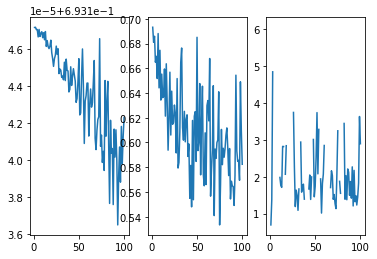

In [174]:
w0 = np.zeros(90,)
b0 = 0
print("μ  is too small")
(w , b , val_cost_arr , iter_arr) = run_gradient_descent(w0 ,b0, train_norm_xs, train_ts, mu=0.000001, batch_size=100, max_iters=100)
plt.subplot(131)
plt.plot(iter_arr , val_cost_arr )

print(" ")
print("μ  is good ")
(w , b , val_cost_arr , iter_arr) = run_gradient_descent(w0 ,b0, train_norm_xs, train_ts, mu=0.1, batch_size=100, max_iters=100)
plt.subplot(132)
plt.plot(iter_arr , val_cost_arr )

print(" ")
print("μ  is too large")
(w , b , val_cost_arr , iter_arr) = run_gradient_descent(w0 ,b0, train_norm_xs, train_ts, mu=5, batch_size=100, max_iters=100)
plt.subplot(133)
plt.plot(iter_arr , val_cost_arr )
# Write your code here


**Explain and discuss your results here:**


### Part (g) -- 7%

Find the optimial value of ${\bf w}$ and $b$ using your code. Explain how you chose
the learning rate $\mu$ and the batch size. Show plots demostrating good and bad behaviours.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/usr/local/lib/python3.7

optimal b is : 0.2711497851982131
optimal w is : [ 1.36719756e+00 -9.24328159e-01 -1.76137230e-01 -1.81831373e-02
 -8.29287126e-02 -6.55233797e-01 -5.75061238e-02 -1.32174664e-01
 -1.08765965e-01  2.76578837e-02 -2.43471923e-01  3.99305299e-02
  2.48370803e-01  2.02248268e-01  1.75805457e-02  1.65871959e-01
  4.35665276e-02  3.33080875e-01  1.43769101e-01  1.53082414e-01
  2.04496515e-02  5.75081218e-02  3.57787170e-01  1.19670755e-01
 -1.23131694e-01  4.24219478e-02  1.53763606e-01  2.18125839e-02
 -1.05118372e-01 -7.66940543e-04 -6.21401647e-02  8.72108669e-03
 -1.06938722e-01 -3.07662618e-02  2.63862738e-02 -3.71930654e-02
 -9.82986323e-02  1.49770476e-01  1.82571343e-01  7.19279996e-03
 -1.14114222e-01  9.41300878e-03  6.47595988e-02 -5.02198640e-02
 -3.30629845e-02  5.23118663e-02  6.00604268e-03 -7.58237756e-02
  1.20925946e-02 -7.09882393e-03 -2.25088351e-02 -2.77813006e-02
  9.47761248e-02 -7.13903186e-02 -6.43883488e-02  4.77489760e-02
 -1.60426093e-01  6.22912406e-02 -7.20662

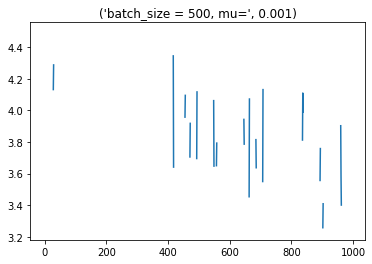

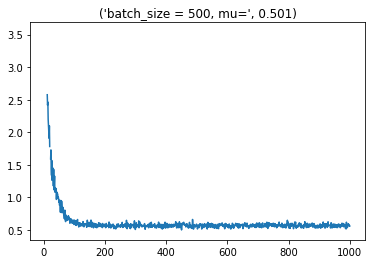

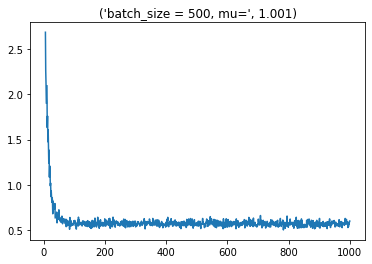

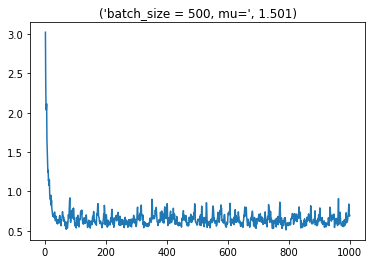

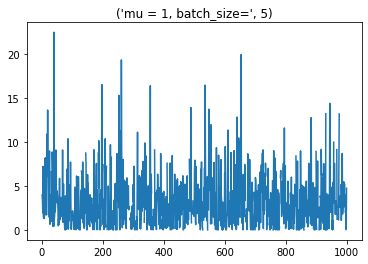

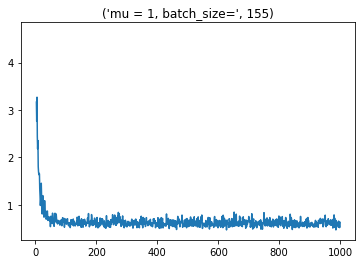

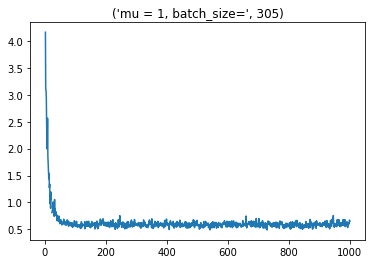

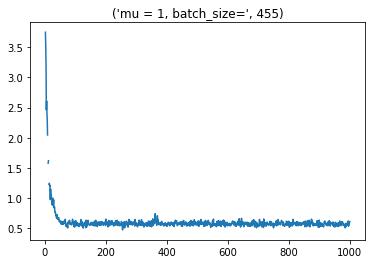

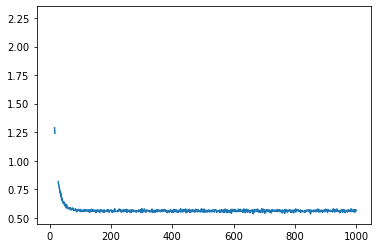

In [256]:
w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]
#w = np.zeros(90,)
#b = 0

#(w1 , b1 , val_cost_arr1 , iter_arr1) = run_gradient_descent(w0 ,b0, train_norm_xs, train_ts, mu=0.05, batch_size=500, max_iters=1000)
#plt.plot(iter_arr1 , val_cost_arr1 )

#(w2 , b2 , val_cost_arr2 , iter_arr2) = run_gradient_descent(w0 ,b0, train_norm_xs, train_ts, mu=2, batch_size=500, max_iters=1000)
#plt.plot(iter_arr2 , val_cost_arr2 )

for i in np.arange(0.001 , 2.001 , 0.5):
  
  (w3 , b3 , val_cost_arr , iter_arr) = run_gradient_descent(w0 ,b0, train_norm_xs, train_ts, mu=i, batch_size=500, max_iters=1000)
  
  plt.figure()
  plt.plot(iter_arr , val_cost_arr  )
  titleStr = 'batch_size = 500, mu=',i
  plt.title(titleStr)

for i in np.arange(5, 600, 150):
  
  (w3 , b3 , val_cost_arr , iter_arr ) = run_gradient_descent(w0 ,b0, train_norm_xs, train_ts, mu=1, batch_size=i, max_iters=1000)
  
  plt.figure()
  plt.plot(iter_arr , val_cost_arr  )
  titleStr = 'mu = 1, batch_size=',i
  plt.title(titleStr)

(w3 , b3 , val_cost_arr , iter_arr ) = run_gradient_descent(w0 ,b0, train_norm_xs, train_ts, mu=1, batch_size=5000, max_iters=1000)
plt.figure()
plt.plot(iter_arr , val_cost_arr  )

(w , b , val_cost_arr , iter_arr) = run_gradient_descent(w0 ,b0, train_norm_xs, train_ts, mu=1, batch_size=455, max_iters=1000)
print("optimal b is :", b)
print("optimal w is :", w)
# Write your code here


**Explain and discuss your results here:**




### Part (h) -- 15%

Using the values of `w` and `b` from part (g), compute your training accuracy, validation accuracy,
and test accuracy. Are there any differences between those three values? If so, why?

In [247]:
# Write your code here

train_acc = get_accuracy( pred(w, b, train_norm_xs) , train_ts )*100

val_acc = get_accuracy( pred(w, b, val_norm_xs) , val_ts )*100

test_acc = get_accuracy( pred(w, b, test_norm_xs) , test_ts )*100

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)


train_acc =  72.8015662956383  val_acc =  73.286  test_acc =  72.23900832849118


**Explain and discuss your results here:**
We got almost the same results in the train, test and validate data sets. It means that the data was successfully classified and we did not get over fitting.


### Part (i) -- 15%

Writing a classifier like this is instructive, and helps you understand what happens when
we train a model. However, in practice, we rarely write model building and training code
from scratch. Instead, we typically use one of the well-tested libraries available in a package.

Use `sklearn.linear_model.LogisticRegression` to build a linear classifier, and make predictions about the test set. Start by reading the
[API documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Compute the training, validation and test accuracy of this model.

In [266]:
import sklearn.linear_model

# Create linear regression object
regr = sklearn.linear_model.LogisticRegression()

# Train the model using the training sets
regr.fit(train_norm_xs, train_ts)

# The acc
train_acc =  regr.score(train_norm_xs,train_ts)

val_acc =  regr.score(val_norm_xs,val_ts)

test_acc =  regr.score(test_norm_xs,test_ts)



print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train_acc =  0.7324438321066434  val_acc =  0.73582  test_acc =  0.726631803215185


**This parts helps by checking if the code worked.**
**Check if you get similar results, if not repair your code**
